# 1. Problem

**Natural Language Processing (NLP) with Disaster Tweets**

In this project, we will build a machine learning model (NLP) that predicts which Tweets are about real disasters and which ones aren’t. This is a binary classification problem and we will be using a Deep Learning model; Recurrent Neural Networks (RNNs).

## About the Dataset

This dataset consists of 10,000 tweets that were hand classified (disaster tweet or not). It provides a `train`, `test` and `sample_submission`. We will use the train dataset to train our model and predict the test dataset.

[LEARN MORE](https://www.kaggle.com/c/nlp-getting-started/data)

### Features

  
1. **id:** a unique identifier for each tweet
2. **text:** the text of the tweet
3. **location:** the location the tweet was sent from (may be blank)
4. **keyword:** a particular keyword from the tweet (may be blank)
5. **target:** in train the dataset only, this denotes whether a tweet is about a real disaster (1) or not (0)



## Import Libraries

In [133]:
! pip install pandas
! pip install kaggle
! pip install seaborn
! pip install wordcloud
! pip install nltk
! pip install tensorflow keras keras-preprocessing
! pip install gensim
! pip install tensorflow_hub
! pip install sklearn-learn

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour chan

In [134]:
# from google.colab import files # uncomment if you're using google colab
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ogooluwaakinola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ogooluwaakinola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load dataset

Visit [here](https://www.kaggle.com/discussions/general/74235) to learn how to download data from Kaggle to google colab

In [135]:
# uncomment if you're using google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [136]:
# ! mkdir ./.kaggle

In [137]:
# copy kaggle.json to .kaggle
# ! cp ~/path/to/kaggle.json ./.kaggle/

In [138]:
# change permissions of the file
# ! chmod 600 ./.kaggle/kaggle.json

In [139]:
# check if everything works well
! kaggle datasets list

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                         1MB  2024-04-10 09:48:38          20841        461  1.0              
jainaru/world-happiness-report-2024-yearly-updated               World Happiness Report- 2024                       62KB  2024-05-15 19:04:34           1519         31  1.0              
sahirmaharajj/school-student-daily-attendance                    School Student Daily Attendance                     2MB  2024-04-29 19:29:56           5379        112  1.0              
jainaru/thyroid-disease-data                                     

In [140]:
# download dataset
# ! kaggle competitions download -c nlp-getting-started

In [141]:
! mkdir nlp-disaster-tweets

mkdir: nlp-disaster-tweets: File exists


In [142]:
# unzip data
! unzip nlp-getting-started.zip -d nlp-disaster-tweets

Archive:  nlp-getting-started.zip
replace nlp-disaster-tweets/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [147]:
# Load the dataset
train_data_file = "nlp-disaster-tweets/train.csv"
test_data_file = "nlp-disaster-tweets/test.csv"
data = pd.read_csv(train_data_file)
data_test = pd.read_csv(test_data_file)

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [148]:
df = data.copy()
df_test = data_test.copy()

**Print data shape**

In [149]:
df.shape

(7613, 5)

In [150]:
df_test.shape

(3263, 4)

In [151]:
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [152]:
df.tail(5)

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [153]:
df_test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


**Print datatypes of dataset**

In [154]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [156]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [157]:
df['target'].unique()

array([1, 0])

In [158]:
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

### Data Cleaning & Preprocessing

**Missing (null) Values**

In [159]:
# count NaN
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

**Drop duplicates (if any)**

In [160]:
df.drop_duplicates(inplace=True)

**Drop unneccessary features**

These are features that do not provide relevant information to the problem such as `keyword`, and `location`.

In [161]:
dropped_features = ['keyword', 'location']

In [162]:
# df.drop(dropped_features, axis=1, inplace=True)

**Data so far ...**

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Visualize target distribution

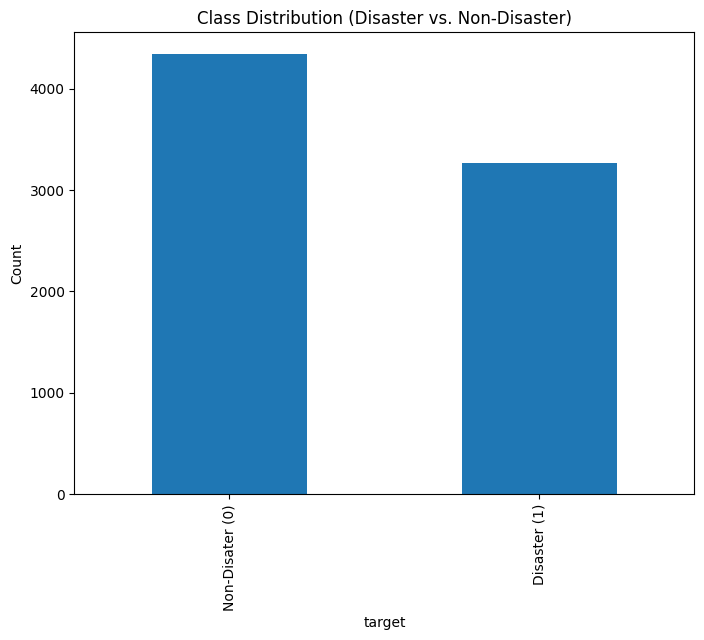

In [164]:
target_counts = df['target'].value_counts()

plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar')
plt.title('Class Distribution (Disaster vs. Non-Disaster)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Disater (0)', 'Disaster (1)'])
plt.show()

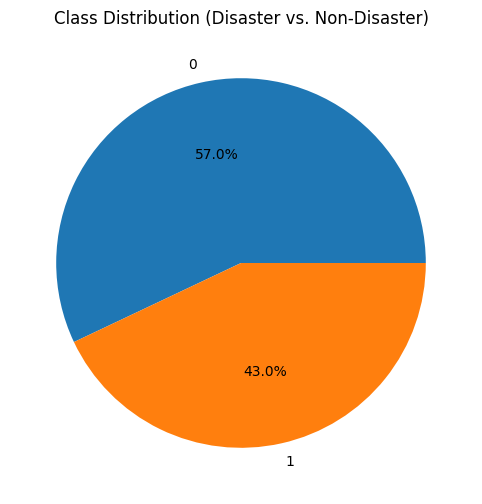

In [165]:
plt.figure(figsize=(8, 6))
target_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Class Distribution (Disaster vs. Non-Disaster)')
plt.ylabel('')  # Remove y-label in pie charts
plt.show()

### Text Analysis

**Word Counts**

In [166]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['word_count'].describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64

**Character Counts**

In [167]:
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
df['char_count'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: char_count, dtype: float64

**Common Words**

In [168]:
# Combine all tweet texts into a single string
all_text = ' '.join(df['text'].astype(str))

# Count the frequency of each word
word_counts = Counter(all_text.split())

# Get the most common words
most_common_words = word_counts.most_common(20)  # Top 20 words
most_common_words

[('the', 2575),
 ('a', 1845),
 ('to', 1805),
 ('in', 1757),
 ('of', 1722),
 ('and', 1302),
 ('I', 1197),
 ('for', 820),
 ('is', 814),
 ('on', 773),
 ('-', 763),
 ('you', 632),
 ('The', 552),
 ('my', 549),
 ('with', 508),
 ('that', 492),
 ('at', 485),
 ('by', 469),
 ('it', 433),
 ('from', 372)]

**Word Cloud**

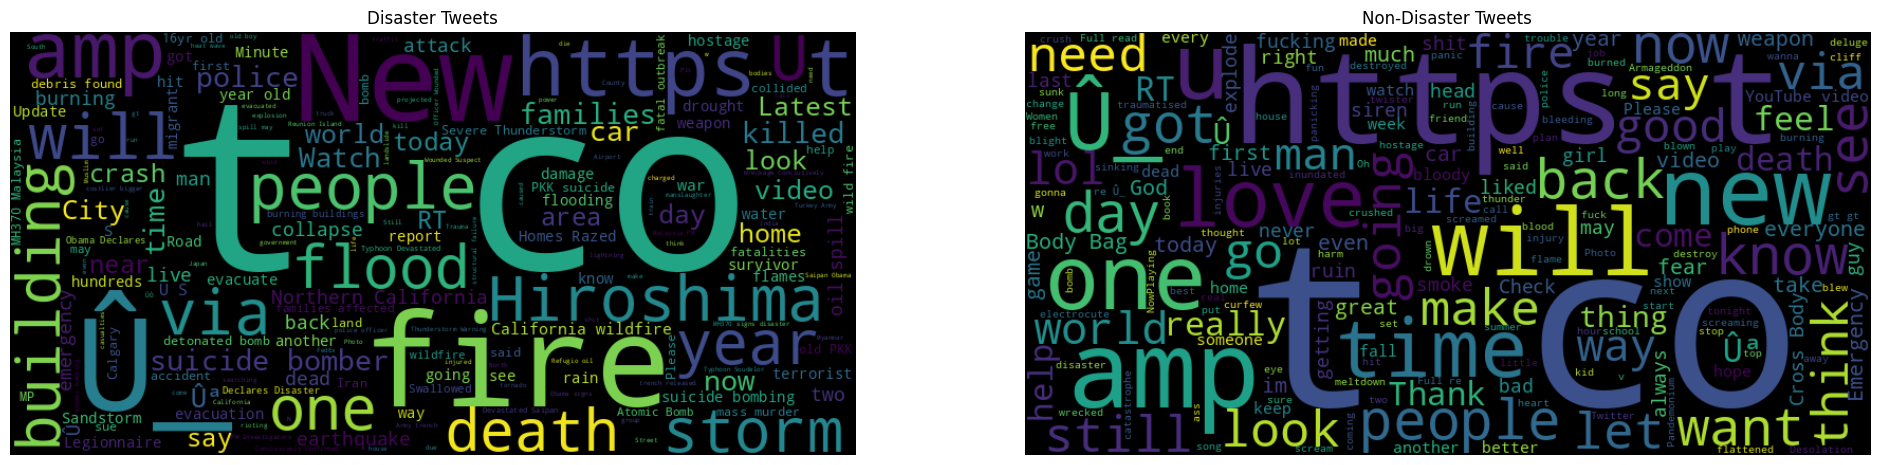

In [169]:
# Create word clouds for each class
disaster_words = ' '.join(df[df['target'] == 1]['text'].astype(str))
non_disaster_words = ' '.join(df[df['target'] == 0]['text'].astype(str))

wc_disaster = WordCloud(width=800, height=400).generate(disaster_words)
wc_non_disaster = WordCloud(width=800, height=400).generate(non_disaster_words)

plt.figure(figsize=(24, 24))
plt.subplot(1, 2, 1)
plt.imshow(wc_disaster, interpolation='bilinear')
plt.title('Disaster Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc_non_disaster, interpolation='bilinear')
plt.title('Non-Disaster Tweets')
plt.axis('off')

plt.show()

### Preprocessing

For our tweet proprocessing steps we will

1. Remove stopwords
2. Tokenize text
3. Apply lemmitization
4. Convert to lowercase

In [170]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase and remove URLs and HTML tags
    text = re.sub(r"http\S+", "", text.lower())
    text = re.sub(r"<.*?>", "", text)
    
    # Tokenize
    words = nltk.word_tokenize(text)
    
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalnum()]
    
    return " ".join(words)

# Apply to your data
df['processed_text'] = df['text'].astype(str).apply(preprocess_text)
df_test['processed_text'] = df_test['text'].astype(str).apply(preprocess_text)

In [171]:
df.head(5)

,id,keyword,location,text,target,word_count,char_count,processed_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident asked place notified officer evacuati...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,got sent photo ruby alaska smoke wildfire pour...


In [172]:
df_test.head(5)

,id,keyword,location,text,processed_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


### Feature engineering

In [173]:
def get_embedded_text(text_list: np.ndarray):
    # 1. Tokenization and Indexing
    max_words = 10000

    # since twitter has a limit of 280 character, 100 is a safe upperbound
    max_len = 100

    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(text_list)
    sequences = tokenizer.texts_to_sequences(text_list)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    # 2. Word2Vec Embeddings
    sentences = [text.split() for text in text_list]
    vector_size=100
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4)
    vocab_size = len(tokenizer.word_index) + 1 # +1 for padding/OOV token
    embedding_dim = 100
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    
    return embedding_matrix, padded_sequences

embedding_matrix, padded_sequences = get_embedded_text(df['processed_text'])
embedding_matrix_test, padded_sequences_test = get_embedded_text(df_test['processed_text'])

# 3. RNN Model and Analysis

**Split train data into train and validation**

In [174]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

In [175]:
def plot_graph(history, metric, title):
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

def get_pred_df(y_ids: list, y_pred: np.ndarray):

    df = pd.DataFrame(columns=['id', 'target'])

    df['id'] = y_ids
    df['target'] = np.round(y_pred.flatten()).astype('int')

    return df

### Model Architectures

We are going to try out 2 architectures one of which is a simple LSTM-Dropout model

#### Model Architecture 1: Simple LSTM with Dropout

```
Embedding -> LSTM -> Dropout -> Dense (output)
```

1. **Embedding Layer:** This is where the text (tokenized and indexed) is converted into dense vector representations using the provided embedding matrix.
2. **LSTM Layer:** This layer captures the long-term dependencies in sequences. This will help the model remember informtion from earlier words in the tweet to make better predictions about the overall context.
3. **Dropout:** The dropout layer to prevent overfitting by randomly deactivating a fraction of the neurons during training.
4. **Dense (Output) Layer:** The final dense layer with a sigmoid activation function is used for binary classification (e.g., disaster vs. non-disaster tweet).

In [176]:
def Simple_RNN(model_, embedding_matrix: np.ndarray, hidden_units = 256):
    model = model_()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1]))
    model.add(LSTM(hidden_units))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

#### Model Architecture 2: Bi-directional LSTM with Dense and Dropout Layers

```
Embedding -> Bidrectional LSTM -> Dropout -> Dense (hidden) -> Droput -> Dense (output)
```

1. **Embedding Layer:** This is where the text (tokenized and indexed) is converted into dense vector representations using the provided embedding matrix.
2. **Bidirectional LSTM Layer:** The bidirectional LSTM layer allows the model to process the input sequence in both directions (forward and backward), capturing contextual information from both sides of each word. By processing the sequence in both directions, the model can understand words and their relationship within the sentence from both contexts, leading to richer representation.
3. **Dropout (1) Layer:** The dropout layer to prevent overfitting by randomly deactivating a fraction of the neurons during training. This is applied to the output of the bidirectional LSTM to reduce overfitting.
4. **Dense (Hidden) Layer:** This is a fully connected hidden layer with 256 units and the ReLU activation function, which introduces non-linearity. It helps to learn complex relationships between the features extracted by the Bidirectional LSTM Layer.
5. **Dropout (2) Layer:** Another dropout layer for regularization after the dense layer.
6. **Dense (Output) Layer:** The final dense layer with a sigmoid activation function is used for binary classification (e.g., disaster vs. non-disaster tweet).

In [177]:
def Bi_RNN(model_, embedding_matrix, hidden_units = 256):
  model = model_()
  model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1]))
  model.add(Bidirectional(LSTM(hidden_units)))
  model.add(Dropout(0.2))

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  return model

#### Architecture Comparison

- **Simple_RNN:** This is a simpler architecture with the potential for learning long-term dependencies.
- **Bi_RNN:** This is a more sophisticated architecture with bidirectional context and additional dense layer, potentially allowing for more accurate predictions at the cost of higher complexity and training time.

### Model Training

In [178]:
model_simple = Simple_RNN(Sequential, embedding_matrix)
model_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
model_simple_history = model_simple.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.5607 - loss: 0.6861 - val_accuracy: 0.5739 - val_loss: 0.6839
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.5650 - loss: 0.6858 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.5621 - loss: 0.6859 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.5688 - loss: 0.6844 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - accuracy: 0.5780 - loss: 0.6812 - val_accuracy: 0.5739 - val_loss: 0.6831
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.5717 - loss: 0.6842 - val_accuracy: 0.5739 - val_loss: 0.6840
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.5746 - loss: 0.6835 - val_accuracy: 0.5739 - val_loss: 0.6839
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.5612 - loss: 0

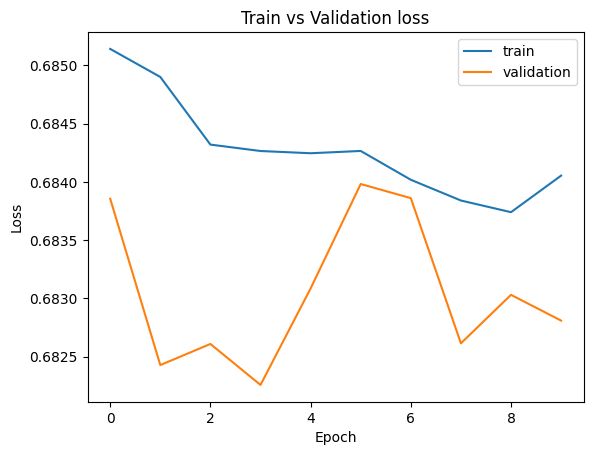

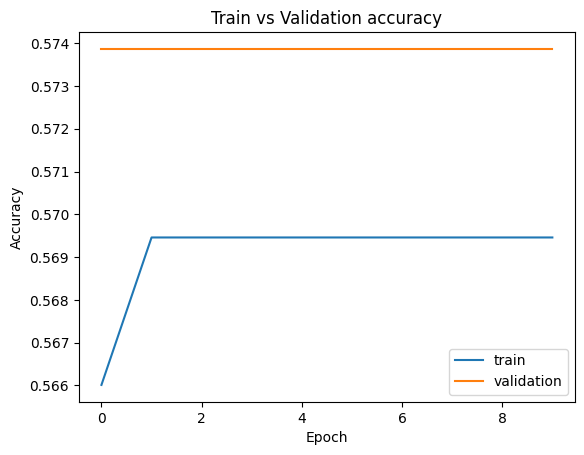

In [179]:
plot_graph(model_simple_history, metric='loss', title='Train vs Validation loss')
plot_graph(model_simple_history, metric='accuracy', title='Train vs Validation accuracy')

From the graph above we can see that the loss curve, saw roughly no decrease (0.68) for both the training and validation dataset.

On the accuracy, we also observed roughly no change in value (0.57) for both the training and validation dataset.

In [180]:
model_simple_pred = model_simple.predict(padded_sequences_test)
model_simple_pred_df = get_pred_df(df_test['id'], model_simple_pred)
model_simple_pred_df.to_csv("RNN_model_simple.csv", index=False)
model_simple_pred_df

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [181]:
model_BI = Bi_RNN(Sequential, embedding_matrix)
model_BI.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
model_BI_history = model_BI.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=256)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.5885 - loss: 0.6798 - val_accuracy: 0.7288 - val_loss: 0.5566
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step - accuracy: 0.8198 - loss: 0.4339 - val_accuracy: 0.7997 - val_loss: 0.4493
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.8987 - loss: 0.2589 - val_accuracy: 0.7827 - val_loss: 0.5226
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - accuracy: 0.9366 - loss: 0.1812 - val_accuracy: 0.7761 - val_loss: 0.6050
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.9587 - loss: 0.1245 - val_accuracy: 0.7636 - val_loss: 0.7233
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 388ms/step - accuracy: 0.9675 - loss: 0.0927 - val_accuracy: 0.7636 - val_loss: 0.7537
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 388ms/step - accuracy: 0.9757 - loss: 0.0750 - val_accuracy: 0.7452 - val_loss: 0.9178
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 469ms/step - accuracy: 0.9743 - loss: 0.0709 - val_accuracy:

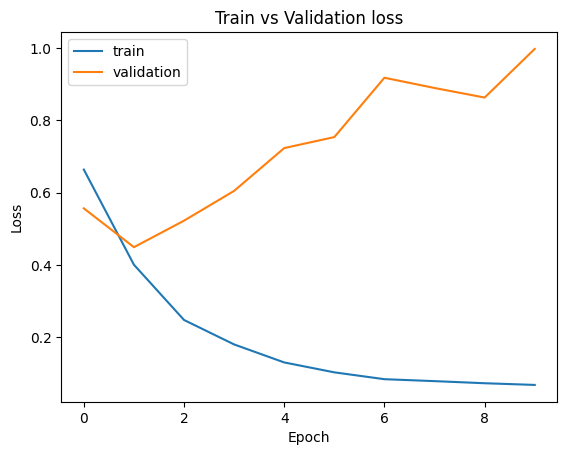

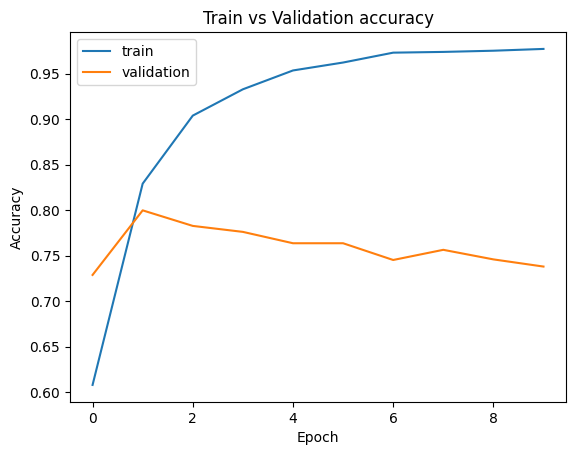

In [182]:
plot_graph(model_BI_history, metric='loss', title='Train vs Validation loss')
plot_graph(model_BI_history, metric='accuracy', title='Train vs Validation accuracy')

From the graph above we can see that the loss curve, saw a steady decrease (0.67 - 0.08) for the training dataset, while an increase (0.51 - 0.95) can be seen for the validation data.

On the accuracy, we observed a steady increase (0.58 - 0.97) for the training dataset, while it remained roughly the same  (0.73) for the validation data.

In [183]:
model_BI_pred = model_BI.predict(padded_sequences_test)
model_BI_pred_df = get_pred_df(df_test['id'], model_BI_pred)
model_BI_pred_df.to_csv("RNN_model_BI.csv", index=False)
model_BI_pred_df

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step


,id,target
0,0,1
1,2,0
2,3,0
3,9,1
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,1


### Hyperparameter tunning

We will try to improve our models by using learning rate scheduling and early stopping.

In [184]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3,
                                     restore_best_weights=True, min_delta=0.0003)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                    patience=3, min_lr=0.0001)

**simple model**

In [185]:
model_simple_2 = Simple_RNN(Sequential, embedding_matrix)
model_simple_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
model_simple_2_history = model_simple_2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], batch_size=256)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.5628 - loss: 0.6853 - val_accuracy: 0.5739 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - accuracy: 0.5696 - loss: 0.6836 - val_accuracy: 0.5739 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.5804 - loss: 0.6812 - val_accuracy: 0.5739 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.5658 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.5767 - loss: 0.6821 - val_accuracy: 0.5739 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.5642 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - accuracy: 0.5645 - loss: 0.6855 - 

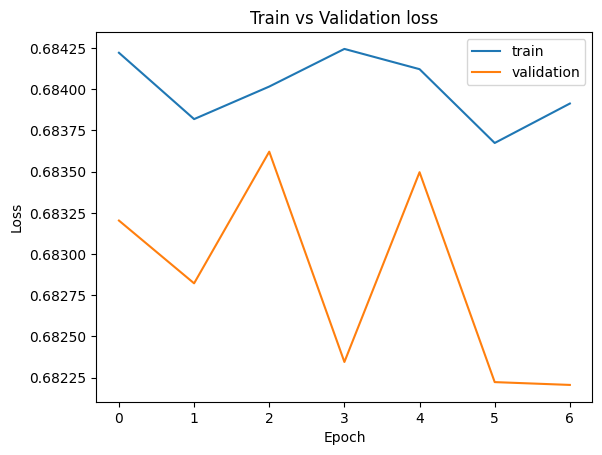

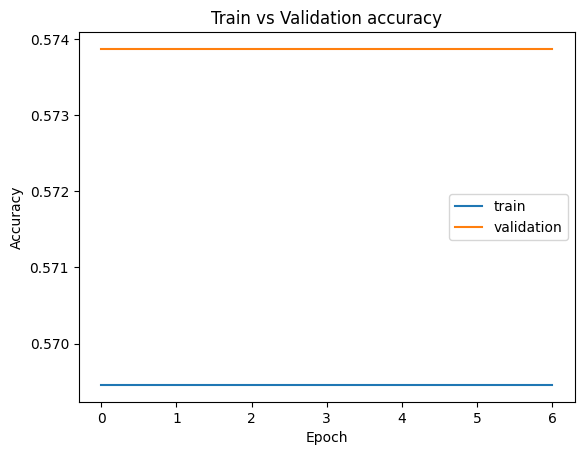

In [186]:
plot_graph(model_simple_2_history, metric='loss', title='Train vs Validation loss')
plot_graph(model_simple_2_history, metric='accuracy', title='Train vs Validation accuracy')

From the graph above we can see that the loss curve, before the early stopping took effect, saw a tiny decrease (0.69 - 0.68) for the training dataset, while the loss (0.68) were practically the same for the validation data.

On the accuracy, we observed roughly no change in value (0.57) for both the training and validation dataset, which means no improvement from before the hyperparameter tunning.

In [187]:
model_simple_2_pred = model_simple_2.predict(padded_sequences_test)
model_simple_2_pred_df = get_pred_df(df_test['id'], model_simple_2_pred)
model_simple_2_pred_df.to_csv("RNN_model_simple_2.csv", index=False)
model_simple_2_pred_df

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


**Bi-directional model**

In [188]:
model_BI_2 = Bi_RNN(Sequential, embedding_matrix)
model_BI_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
model_BI_2_history = model_BI_2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], batch_size=256)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 405ms/step - accuracy: 0.5589 - loss: 0.6747 - val_accuracy: 0.7663 - val_loss: 0.5075 - learning_rate: 0.0010
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.8359 - loss: 0.3937 - val_accuracy: 0.8050 - val_loss: 0.4413 - learning_rate: 0.0010
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step - accuracy: 0.9009 - loss: 0.2565 - val_accuracy: 0.7886 - val_loss: 0.5337 - learning_rate: 0.0010
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.9387 - loss: 0.1628 - val_accuracy: 0.7722 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.9582 - loss: 0.1241 - val_accuracy: 0.7597 - val_loss: 0.8190 - learning_rate: 0.0010


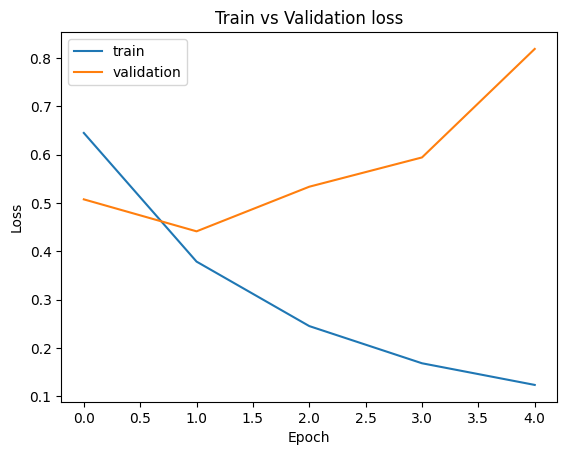

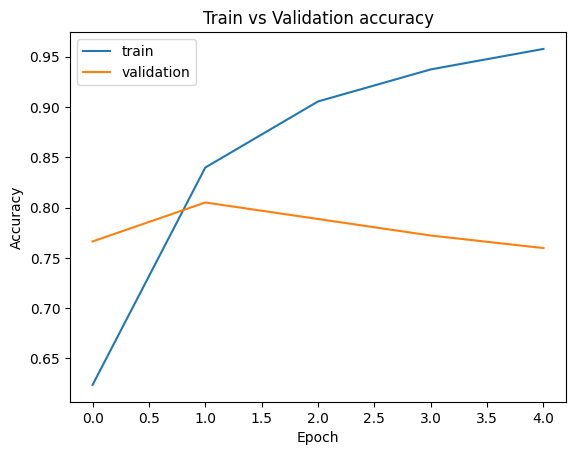

In [189]:
plot_graph(model_BI_2_history, metric='loss', title='Train vs Validation loss')
plot_graph(model_BI_2_history, metric='accuracy', title='Train vs Validation accuracy')

From the graph above we can see that the loss curve, before the early stopping took effect, saw a steady decrease (0.68 - 0.10) for the training dataset, while a slight increase (0.56 - 0.72) can be seen for the validation data.

On the accuracy, we observed a steady increase (0.6 - 0.96) for the training dataset, while a slight increase (0.71 - 0.76) can be seen for the validation data, a negligible improvement from before the hyperparameter tunning.

In [190]:
model_BI_2_pred = model_BI_2.predict(padded_sequences_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


In [191]:
model_BI_2_pred_df = get_pred_df(df_test['id'], model_BI_2_pred)
model_BI_2_pred_df

,id,target
0,0,1
1,2,0
2,3,0
3,9,1
4,11,0
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,1


In [192]:
# save to csv
model_BI_2_pred_df.to_csv("RNN_model_BI_2.csv", index=False)

# 4. Discussion & Conclusion

For our RNN model, we chose two models, a simple LSTM and a more complex bidirectional LSTM.

The simple LSTM model was faster, but showed little to no improvement with accuracy even after hyperparameter tunning.

The complex bidirectional LSTM, showed a better improvement in accuracy compared with the simple model.

On hyperparameter tunning, we applied early_stopping and reduction in learning rates if loss plateaus. 

In conclusion, bidirectional LSTM model performed better than the simpler model. However, the optimization wasn't very much helpful in improving the model accuracy. Hence, we could try a different architecture.